# PyMC3 test double tanh

Fit the following harmonic model with a trend to some test data with noise,

$$
 \rho(z) = \beta_{0} - \beta_{1}\, \left(\text{tanh} \left(\frac{z + \beta_{2}} {\beta_{3}} \right) 
      + \, \text{tanh} \left(\frac{z + \beta_{2} + \beta_{4}} {\beta_{5}} \right) \right).
$$

Largely following this example [https://am207.github.io/2017/wiki/Lab7_bioassay.html#setting-up-the-model-in-pymc3](https://am207.github.io/2017/wiki/Lab7_bioassay.html#setting-up-the-model-in-pymc3)

This notebook shows show to do the following:

 - Fit a linear model with no time dependence
 - Fit a linear model with time-dependence
 - Fit a nonlinear model with time dependence (double-tanh model)
 - Fit a nonlinear model with time dependence (double-tanh model)
 
We also show various features of the `PyMC3` library.

# Inference step

See the documentation for a list of step methods (Metropolis, Hamiltonian MC): [https://docs.pymc.io/api/inference.html](https://docs.pymc.io/api/inference.html)
 

# Bayesian Hierarchical Model

(Stolen from Manderson, et al, ...)

$$
  \pmb{y}_{t}(z) = \beta_{0, t} - \beta_{1, t}\, \left(\text{tanh} \left(\frac{\pmb{z}_{t} + \beta_{2, t}} {\beta_{3, t}} \right) 
      + \, \text{tanh} \left(\frac{\pmb{z}_{t} + \beta_{2, t} + \beta_{4, t}} {\beta_{5, t}} \right) \right) + \pmb{\varepsilon}_{t},
$$

These are our regression parameters:

$$
    \pmb{\beta_{0}} \sim \text{N}\left(\mu_{\beta_{0}}, \sigma^2_{\beta_{0}} \right) \quad
    \pmb{\beta}_{1} \sim \text{N} \left(\mu_{\beta_{1}}, \sigma^2_{\beta_{1}}\right) \quad
    \pmb{\beta}_{0}, \, \pmb{\beta}_{1} > 0, \\
    \pmb{\beta}_{3} \sim \text{N} \left(\mu_{\beta_{3}}, \sigma^2_{\beta_{3}}\right) \quad
    \pmb{\beta}_{5} \sim \text{N} \left(\mu_{\beta_{5}}, \sigma^2_{\beta_{5}}\right) \qquad \pmb{\beta}_{3}, \, \pmb{\beta}_{5} > 0,\\
    \pmb{\beta}_{2} \sim \text{N} \left(\mu_{\beta_{2}}, \sigma^2_{\beta_{2}}\right) \quad
    \pmb{\beta}_{4} \sim \text{N} \left(\mu_{\beta_{4}}, \sigma^2_{\beta_{4}}\right) \qquad 0 < \pmb{\beta}_{2} < \pmb{\beta}_{4},\\
$$
where $\pmb{\beta_{0}} = (\beta_{0,1},~\beta_{0,2},~...~,~\beta_{0,T})$, and similarly   for all other regression parameters.

The priors for our means ($\mu_{\beta}$'s) are:

$$
 \mu_{\beta_{0}} \sim \text{N}(1025, 10^2) \qquad \qquad 
    \mu_{\beta_{1}} \sim \text{N} (5 , 2^2)  \qquad \qquad
    \mu_{\beta_{0}}, \, \mu_{\beta_{1}} > 0 \\
    \mu_{\beta_{3}} \sim \text{N} (80, 15^2) \qquad \mu_{\beta_{5}} \sim \text{N} (80, 15^2)  \qquad \qquad
    \mu_{\beta_{3}}, \, \mu_{\beta_{5}} > 0 \\
    \mu_{\beta_{2}} \sim \text{N} (75, 15^2) \qquad \mu_{\beta_{4}} \sim \text{N} (150, 15^2) \qquad \qquad 
    0 < \mu_{\beta_{2}} < \mu_{\beta_{4}}
$$

Note that our means even have a distribution !!??!!
The density profile at a specific time $t$ is a deviation from this mean. Our goal is to estimate the mean values of our $\beta$ parameters (and their distributions) across all time points.

If we were to use just a single time point, the mean and variance would be a single value rather than a distribution of points.

In [1]:
import pymc3 as pm
import numpy as np
import pandas as pd
import xarray as xr
import matplotlib.pyplot as plt
from datetime import datetime

from scipy.optimize import fmin_powell, fmin, fmin_cg, fmin_ncg
import seaborn as sns

from theano import shared
from theano import tensor as tt

import matplotlib as mpl
sns.set()

%matplotlib inline

mpl.rcParams['font.size'] = 14
mpl.rcParams['axes.labelsize'] = 'large'

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
# Our model functions
def double_tanh_pm(beta, z):
    """
    Double-tanh function that accepts PyMC3 objects instead of numpy arrays
    """
    fac1 = (z+beta[2])/beta[3]
    fac2 = (z+beta[2]+beta[4])/beta[5]
    return beta[0] - beta[1]*( pm.math.tanh(fac1)
                + pm.math.tanh(fac2))

def double_tanh(beta, z):
    
    return beta[0] - beta[1]*(np.tanh((z+beta[2])/beta[3])
                + np.tanh((z+beta[2]+beta[4])/beta[5]))



In [3]:
def convert_time(tt):
    try:
        dt= datetime.strptime(tt, '%Y-%m-%dT%H:%M:%S')
    except:
        dt= datetime.strptime(tt, '%Y-%m-%d %H:%M')
    return dt

def read_density_csv(csvfile):
    # Reads into a dataframe object
    df = pd.read_csv(csvfile, index_col=0, sep=', ', parse_dates=['Time'], date_parser=convert_time)

    # Load the csv data
    depths= np.array([float(ii) for ii in df.columns.values])
    rho_obs_tmp = df[:].values.astype(float)
    time = df.index[:]

    # Clip the top
    rho_obs_2d = rho_obs_tmp[:,:]

    # Remove some nan
    fill_value = 1024.
    rho_obs_2d[np.isnan(rho_obs_2d)] = fill_value
    
    return xr.DataArray(rho_obs_2d,dims=('time', 'depth'),
            coords={'time':time.values,'depth':depths})


In [4]:
#############
# Input Data

datafile1 = 'DATA_QC/Crux_KP150_Phs1_Density_lowpass'
datafile2 = 'DATA_QC/Crux_KP150_Phs2_Density_lowpass'
sitename = 'CRUX'
zmin = -250

#datafile1 = 'DATA_QC/IMOS_Density_PIL200_2013_b'
#datafile2 = 'DATA_QC/IMOS_Density_PIL200_2014_a'
#sitename = 'PIL200'
#zmin = -205

#datafile1 = 'DATA_QC/IMOS_Density_KIM200_2013_b'
#datafile2 = 'DATA_QC/IMOS_Density_KIM200_2014_a'
#sitename = 'KIM200'
#zmin = -205
#############

rho1 = read_density_csv('%s.csv'%datafile1)
rho2 = read_density_csv('%s.csv'%datafile2)

# Grab a small sample for testing first...
#rho = xr.concat([rho1,rho2], dim='time')
#rho = rho1.sel(time=slice('2016-05-01','2016-05-02'))
rho = rho2
nt,nz = rho.shape

depths_2d = rho.depth.values[np.newaxis,:].repeat(nt, axis=0)

zout = np.linspace(zmin,0,100)
rho, nt,nz

/home/suntans/.conda/envs/soda/lib/python3.6/site-packages/ipykernel_launcher.py:10: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  # Remove the CWD from sys.path while we load stuff.


(<xarray.DataArray (time: 750, depth: 12)>
 array([[1025.8655, 1025.6474, 1025.4783, ..., 1021.6923, 1021.1381, 1021.1196],
        [1025.8351, 1025.6149, 1025.4283, ..., 1021.6336, 1021.1429, 1021.1258],
        [1025.8092, 1025.5864, 1025.3866, ..., 1021.578 , 1021.1477, 1021.1317],
        ...,
        [1026.0198, 1025.7399, 1025.5525, ..., 1021.5754, 1021.5571, 1021.5513],
        [1026.0087, 1025.7564, 1025.5539, ..., 1021.5695, 1021.5503, 1021.544 ],
        [1026.017 , 1025.7993, 1025.583 , ..., 1021.6404, 1021.6203, 1021.6138]])
 Coordinates:
   * time     (time) datetime64[ns] 2016-10-31T06:40:00 2016-10-31T12:40:00 ...
   * depth    (depth) float64 -250.5 -227.8 -203.6 -179.4 -155.2 -131.0 ...,
 750,
 12)

# Time-dependent model

Here we construct the time-dependent model i.e. where each time step has information about other time steps through the $\mu_{\beta}$ parameters.

In [16]:
# Full model
with pm.Model() as rho_model:
    ###
    # Create priors for each of our means
    #BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    
    # Use a dictionary so we can look up the parameters easily
    mu_betas = dict(
        mu_beta_0 = pm.Normal('mu_beta_0', mu=1025.0, sd=10.0,),
        mu_beta_1 = pm.Normal('mu_beta_1', mu=1., sd=0.25,),
        mu_beta_2 = pm.Normal('mu_beta_2', mu=75.0, sd=30.0,),
        mu_beta_3 = pm.Normal('mu_beta_3', mu=80.0, sd=30.0,),
        mu_beta_4 = pm.Normal('mu_beta_4', mu=75.0, sd=40.0,),
        mu_beta_5 = pm.Normal('mu_beta_5', mu=80.0, sd=40.0,),
        #mu_beta_1 = BoundedNormal('mu_beta_1', mu=1., sd=0.5,),
        #mu_beta_2 = BoundedNormal('mu_beta_2', mu=75.0, sd=15.0,),
        #mu_beta_3 = BoundedNormal('mu_beta_3', mu=80.0, sd=15.0,),
        #mu_beta_4 = BoundedNormal('mu_beta_4', mu=75.0, sd=15.0,),
        #mu_beta_5 = BoundedNormal('mu_beta_5', mu=80.0, sd=15.0,),
    )
    
    nparams=6
    
    # ???
    sigma_beta = pm.HalfNormal('sigma_beta', sd=15, shape=(nparams,))
    sigma_curve = pm.HalfNormal('sigma_curve', sd=0.25 )
    #sigma_curve = pm.HalfNormal('sigma_curve', sd=0.08 )
    
    # Initial guesses
    #sigma_beta = [0.18,0.12,26.1,8.09,12.6,6.65]
    #sigma_curve = 0.08
    
    #sigma_beta = []
    #sigma_beta.append(pm.HalfNormal('sigma_beta_0', sd=0.25 ))
    #sigma_beta.append(pm.HalfNormal('sigma_beta_1', sd=0.15 ))
    #sigma_beta.append(pm.HalfNormal('sigma_beta_2', sd=15. ))
    #sigma_beta.append(pm.HalfNormal('sigma_beta_3', sd=10. ))
    #sigma_beta.append(pm.HalfNormal('sigma_beta_4', sd=15. ))
    #sigma_beta.append(pm.HalfNormal('sigma_beta_5', sd=10. ))


    beta_s = []
    for ii in range(nparams):
        #if ii in [1,2,3,4,5]:
        #    # Replace beta_1 and beta_4 with bounds
        #    beta_s.append(BoundedNormal('beta_%d'%ii,\
        #            mu=mu_betas['mu_beta_%d'%ii], sd=sigma_beta[ii], shape=nt))
        #else:
        beta_s.append(pm.Normal('beta_%d'%ii,\
            mu=mu_betas['mu_beta_%d'%ii], sd=sigma_beta[ii], shape=nt))
    
    ###
    # Generate the likelihood function using the deterministic variable as the mean
    mu_x = double_tanh_pm(beta_s, depths_2d.T)
    
    #rho = pm.Normal('rho', mu=mu_x, sd=sigma_curve, observed=rho_obs_2d.T, shape=(nt,))
    #rho = pm.Normal('rho', mu=mu_x, sd=sigma_curve, observed=rho_obs_2d.T, shape=(nz,))
    #rho = pm.Normal('rho', mu=mu_x, sd=sigma_curve, observed=rho_obs_2d.T, shape=(nt,nz))
    
    # shape parameter not requires as shape is specified in the priors...
    rho_out = pm.Normal('rho', mu=mu_x, sd=sigma_curve, observed=rho.values.T)

    # Initial values (Not used)
    initvals = {
    'mu_beta_0': 1025.,
    'mu_beta_1': 1.,
    'mu_beta_2': 75.,
    'mu_beta_3': 80.,
    'mu_beta_4': 75.,
    'mu_beta_5': 80.,
    'sigma_curve': 0.08,
    'sigma_beta': np.array([0.18,0.12,26.1,8.09,12.6,6.65]),
    'beta_0': 1025.*np.ones((nt,)),
    'beta_1': 1.*np.ones((nt,)),
    'beta_2': 75.*np.ones((nt,)),
    'beta_3': 80.*np.ones((nt,)),
    'beta_4': 75.*np.ones((nt,)),
    'beta_5': 80.*np.ones((nt,)),
    }
    ###
    # Inference step
    #start = pm.find_MAP()
    #step = pm.NUTS(target_accept=0.90, scaling=start)
    #step = None
    #trace = pm.sample(1000, tune=2500, step=step, cores=2)
    trace = pm.sample(500, tune=2000, cores=3, start=None,\
            nuts_kwargs=dict(target_accept=0.95, max_treedepth=16, k=0.5))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [beta_5, beta_4, beta_3, beta_2, beta_1, beta_0, sigma_curve_log__, sigma_beta_log__, mu_beta_5, mu_beta_4, mu_beta_3, mu_beta_2, mu_beta_1, mu_beta_0]
100%|██████████| 2500/2500 [1:12:00<00:00,  1.73s/it]  
The gelman-rubin statistic is larger than 1.4 for some parameters. The sampler did not converge.
The estimated number of effective samples is smaller than 200 for some parameters.


In [17]:
params = pm.summary(trace)
params[:]

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu_beta_0,1023.430569,0.006498,0.000415,1023.415530,1023.442144,61.177812,1.007091
mu_beta_1,1.246449,0.002969,0.000277,1.240170,1.251797,23.447902,1.007190
mu_beta_2,62.546318,0.363937,0.031442,61.823249,63.323141,28.743554,1.014140
mu_beta_3,62.001658,0.679027,0.052550,60.666030,63.417106,40.228205,1.005088
mu_beta_4,92.608366,0.333381,0.020645,91.989725,93.272446,73.434606,1.008221
mu_beta_5,53.805226,0.536219,0.034402,52.679619,54.817926,83.445946,1.010494
beta_0__0,1023.334375,0.041144,0.000978,1023.255324,1023.417338,1637.531806,1.000271
beta_0__1,1023.316738,0.040138,0.000891,1023.237757,1023.394814,1959.174830,0.999366
beta_0__2,1023.302784,0.041277,0.001025,1023.223056,1023.380693,1575.839889,1.001850
beta_0__3,1023.288059,0.042028,0.001110,1023.210340,1023.374053,1460.725790,1.002277


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f6edc342128>,
      dtype=object)

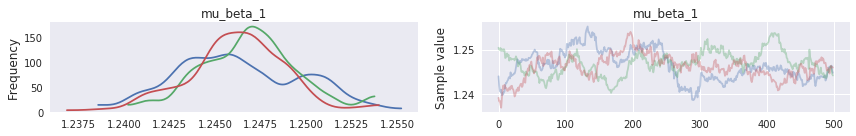

In [18]:
pm.traceplot(trace[:], varnames=['mu_beta_1'])

Text(0.5,1,'2017-05-01T18:40:00.000000000')

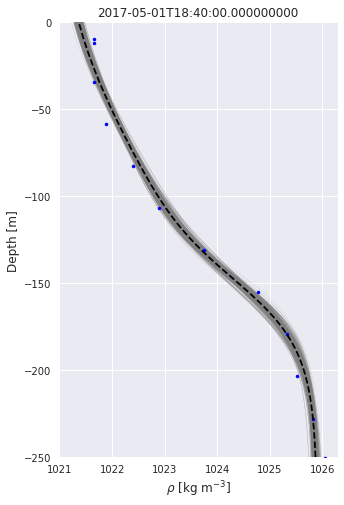

In [19]:
tstep = -20
rhomean = np.zeros_like(zout)

plt.figure(figsize=(5,8))
samples = 500
for rand_loc in np.random.randint(0, len(trace), samples):
    rs = trace[rand_loc]
    rhotmp = double_tanh([rs['beta_%d'%ii][tstep] for ii in range(6)], zout)
    plt.plot(rhotmp, zout, '0.5', lw=0.2, alpha=0.5)
    
    #rhotmp = double_tanh([rs['beta_%d'%ii][tstep+180] for ii in range(6)], zout)
    #plt.plot(rhotmp, zout, 'r', lw=0.2, alpha=0.5)
    
    rhomean+=rhotmp
    
plt.plot(rho.values[tstep,:],depths_2d[tstep,:], 'b.')
#plt.plot(rho.values[tstep+180,:],depths_2d[tstep,:], 'y.')


rhomean /= samples
plt.plot(rhomean, zout, 'k--',) # Mean fit

plt.ylim(zmin,0 )
plt.ylabel('Depth [m]')
plt.xlabel(r'$\rho$ [kg m$^{-3}$]')
plt.title(rho.time.values[tstep])

#plt.savefig('pymc3_crux_fit_%d.png'%tstep)
#plt.savefig('pymc3_crux_fit_%d.pdf'%tstep)


In [35]:
trace.varnames

['mu_beta_0',
 'mu_beta_1_lowerbound__',
 'mu_beta_2_lowerbound__',
 'mu_beta_3_lowerbound__',
 'mu_beta_4_lowerbound__',
 'mu_beta_5_lowerbound__',
 'sigma_curve_log__',
 'beta_0',
 'beta_1_lowerbound__',
 'beta_2_lowerbound__',
 'beta_3_lowerbound__',
 'beta_4_lowerbound__',
 'beta_5_lowerbound__',
 'mu_beta_1',
 'mu_beta_2',
 'mu_beta_3',
 'mu_beta_4',
 'mu_beta_5',
 'sigma_curve',
 'beta_1',
 'beta_2',
 'beta_3',
 'beta_4',
 'beta_5']

In [ ]:
# Convert the trace ('beta_samples') to a hdf5 (nparams, nt, samples)
beta_samples = np.zeros((6,nt,nsamples))

# New model

In [8]:
# Our model functions
def double_tanh_7_pm(beta, z):
    """
    Double-tanh function that accepts PyMC3 objects instead of numpy arrays
    """
    fac1 = (z+beta[2])/beta[3]
    fac2 = (z+beta[2]+beta[4])/beta[5]
    return beta[0] - beta[1]* pm.math.tanh(fac1)\
                - beta[6]*pm.math.tanh(fac2)

def double_tanh_7(beta, z):
    
    return beta[0] - beta[1]*np.tanh((z+beta[2])/beta[3])\
                - beta[6]*np.tanh((z+beta[2]+beta[4])/beta[5])
    
    # Our model functions
def single_tanh_pm(beta, z):
    """
    Double-tanh function that accepts PyMC3 objects instead of numpy arrays
    """
    fac1 = (z+beta[2])/beta[3]
    return beta[0] - beta[1]* pm.math.tanh(fac1)

def single_tanh(beta, z):
    
    return beta[0] - beta[1]*np.tanh((z+beta[2])/beta[3])


In [10]:
# Full model
with pm.Model() as rho_model:
    ###
    # Create priors for each of our means
    BoundedNormal = pm.Bound(pm.Normal, lower=0.0)
    
    # Use a dictionary so we can look up the parameters easily
    mu_betas = dict(
        mu_beta_0 = pm.Normal('mu_beta_0', mu=1025.0, sd=10.0,),
        mu_beta_1 = pm.Normal('mu_beta_1', mu=1., sd=0.4,),
        mu_beta_2 = pm.Normal('mu_beta_2', mu=75.0, sd=30.0,),
        mu_beta_3 = pm.Normal('mu_beta_3', mu=80.0, sd=15.0,),
        #mu_beta_4 = pm.Normal('mu_beta_4', mu=75.0, sd=15.0,),
        #mu_beta_5 = pm.Normal('mu_beta_5', mu=80.0, sd=40.0,),
        #mu_beta_6 = pm.Normal('mu_beta_6', mu=1, sd=0.4,),

        #mu_beta_4 = BoundedNormal('mu_beta_4', mu=75.0, sd=30.0),
        #mu_beta_5 = BoundedNormal('mu_beta_5', mu=80.0, sd=40.0,),
        #mu_beta_6 = BoundedNormal('mu_beta_6', mu=0., sd=0.5,), # Second pycnocline density difference
    )
    
    nparams=4
    
    # ???
    sigma_beta = pm.HalfNormal('sigma_beta', sd=15, shape=(nparams,))
    sigma_curve = pm.HalfNormal('sigma_curve', sd=0.5 )
    #sigma_curve = pm.HalfNormal('sigma_curve', sd=0.08 )
    
    # Initial guesses
    #sigma_beta = [0.18,0.12,26.1,8.09,12.6,6.65]
    #sigma_curve = 0.08
    
    #sigma_beta = []
    #sigma_beta.append(pm.HalfNormal('sigma_beta_0', sd=0.5 ))
    #sigma_beta.append(pm.HalfNormal('sigma_beta_1', sd=0.5 ))
    #sigma_beta.append(pm.HalfNormal('sigma_beta_2', sd=15. ))
    #sigma_beta.append(pm.HalfNormal('sigma_beta_3', sd=10. ))
    #sigma_beta.append(pm.HalfNormal('sigma_beta_4', sd=15. ))
    #sigma_beta.append(pm.HalfNormal('sigma_beta_5', sd=10. ))
    #sigma_beta.append(pm.HalfNormal('sigma_beta_6', sd=0.5 ))



    beta_s = []
    for ii in range(nparams):
        #if ii in [4,5,6]:
        #    beta_s.append(BoundedNormal('beta_%d'%ii,\
        #         mu=mu_betas['mu_beta_%d'%ii], sd=sigma_beta[ii], shape=nt))
        #if ii == 6:
        #    beta_s.append(pm.HalfNormal('beta_%d'%ii,\
        #        sd=sigma_beta[ii], shape=nt))
        #else:
        beta_s.append(pm.Normal('beta_%d'%ii,\
            mu=mu_betas['mu_beta_%d'%ii], sd=sigma_beta[ii], shape=nt))
    
    ###
    # Generate the likelihood function using the deterministic variable as the mean
    mu_x = single_tanh_pm(beta_s, depths_2d.T)
    

    # shape parameter not requires as shape is specified in the priors...
    rho_out = pm.Normal('rho', mu=mu_x, sd=sigma_curve, observed=rho.values.T)

    ###
    # Inference step
    #start = pm.find_MAP()
    #step = pm.NUTS(target_accept=0.90, scaling=start)
    #step = None
    #trace = pm.sample(1000, tune=2500, step=step, cores=2)
    trace = pm.sample(500, tune=2000, cores=3, start=None,\
            nuts_kwargs=dict(target_accept=0.95, max_treedepth=16, k=0.5))

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (3 chains in 3 jobs)
NUTS: [beta_3, beta_2, beta_1, beta_0, sigma_curve_log__, sigma_beta_log__, mu_beta_3, mu_beta_2, mu_beta_1, mu_beta_0]
100%|██████████| 2500/2500 [09:05<00:00,  4.58it/s]
The gelman-rubin statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


In [11]:
params = pm.summary(trace)
params[:]

,mean,sd,mc_error,hpd_2.5,hpd_97.5,n_eff,Rhat
mu_beta_0,1023.484525,0.004617,0.000199,1023.476400,1023.494374,456.627986,1.015545
mu_beta_1,2.775451,0.007833,0.000675,2.760276,2.790798,66.830433,1.050677
mu_beta_2,112.696987,0.338242,0.011967,112.109402,113.454688,620.492625,1.008381
mu_beta_3,100.877952,0.466129,0.040289,100.015376,101.840143,66.117129,1.049978
beta_0__0,1023.445523,0.053455,0.001349,1023.345310,1023.547885,1679.765146,0.999612
beta_0__1,1023.429541,0.053782,0.001205,1023.328812,1023.541961,1962.176407,0.999192
beta_0__2,1023.417802,0.055519,0.001225,1023.308677,1023.517099,1812.978854,0.999608
beta_0__3,1023.410580,0.058929,0.001398,1023.278984,1023.516660,1875.167353,0.999485
beta_0__4,1023.403293,0.054698,0.001261,1023.301839,1023.509621,1800.135375,0.999584
beta_0__5,1023.404385,0.057436,0.001358,1023.292184,1023.518019,1884.639850,0.999718


Text(0.5,1,'2017-05-06T12:40:00.000000000')

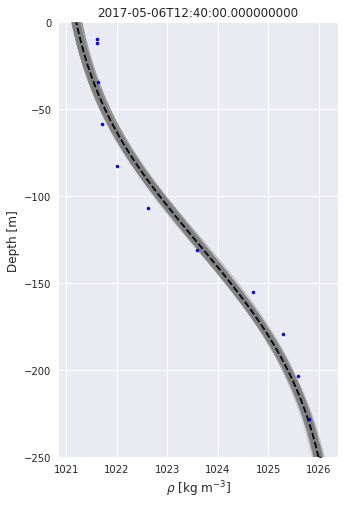

In [15]:
tstep = -1
rhomean = np.zeros_like(zout)

plt.figure(figsize=(5,8))
samples = 500
for rand_loc in np.random.randint(0, len(trace), samples):
    rs = trace[rand_loc]
    rhotmp = single_tanh([rs['beta_%d'%ii][tstep] for ii in range(4)], zout)
    plt.plot(rhotmp, zout, '0.5', lw=0.2, alpha=0.5)
    
    #rhotmp = double_tanh([rs['beta_%d'%ii][tstep+180] for ii in range(6)], zout)
    #plt.plot(rhotmp, zout, 'r', lw=0.2, alpha=0.5)
    
    rhomean+=rhotmp
    
plt.plot(rho.values[tstep,:],depths_2d[tstep,:], 'b.')
#plt.plot(rho.values[tstep+180,:],depths_2d[tstep,:], 'y.')


rhomean /= samples
plt.plot(rhomean, zout, 'k--',) # Mean fit

plt.ylim(zmin,0 )
plt.ylabel('Depth [m]')
plt.xlabel(r'$\rho$ [kg m$^{-3}$]')
plt.title(rho.time.values[tstep])

#plt.savefig('pymc3_crux_fit_%d.png'%tstep)
#plt.savefig('pymc3_crux_fit_%d.pdf'%tstep)
